In [2]:
import mne
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mne.viz.utils import _plot_sensors_2d
import pyprep
import bids_explorer.architecture as arch
from pathlib import Path
import pyxdf


2025-02-24 14:42:14,463 - numexpr.utils - INFO - Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-02-24 14:42:14,464 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [3]:
root = Path("/data2/Projects/NKI_RS2/MoBI/")
bv_collection = arch.BidsArchitecture(root = root,
                                     datatype = 'raw',
                                     extension = '.vhdr')
lsl_collection = arch.BidsArchitecture(root = root,
                                     datatype = 'lsl')
bids_collection = arch.BidsArchitecture(root = root/'derivatives',
                                        datatype = 'eeg',
                                        suffix = 'electrodes',
                                        extension = '.tsv')
                                        

In [15]:
lsl_collection.select(session = "MOBI1A", task = "checkerboard", run = "01", subject = "M10929703").database

,root,subject,session,datatype,task,run,acquisition,description,suffix,extension,atime,mtime,ctime,filename
154622770145,/data2/Projects/NKI_RS2/MoBI,M10929703,MOBI1A,lsl,checkerboard,01,None,None,lsl,.gz,1708011969,1708011969,1733916561,/data2/Projects/NKI_RS2/MoBI/sub-M10929703/ses...


In [20]:
lsl_collection.database.iloc[25]['filename']

PosixPath('/data2/Projects/NKI_RS2/MoBI/sub-M10945575/ses-MOBI1/lsl/sub-M10945575_ses-MOBI1_task-checkerboard_run-01_lsl.xdf.gz')

In [16]:
bv_collection.database.iloc[0]['filename']

PosixPath('/data2/Projects/NKI_RS2/MoBI/sub-M10942248/ses-MOBI1/raw/sub-M10942248_ses-MOBI1_run-01_eeg.vhdr')

In [22]:
data = pyxdf.load_xdf(lsl_collection.database.iloc[1]['filename'], select_streams={})
                        

2025-01-07 15:13:09,303 - pyxdf.pyxdf - INFO - Importing XDF file /data2/Projects/NKI_RS2/MoBI/sub-M10942248/ses-MOBI1/lsl/sub-M10942248_ses-MOBI1_task-recallpresent_run-01_lsl.xdf.gz...
2025-01-07 15:14:34,778 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2025-01-07 15:14:34,966 - pyxdf.pyxdf - INFO -   performing jitter removal...
2025-01-07 15:14:35,956 - pyxdf.pyxdf - WARNING - Stream 6: Calculated effective sampling rate 112755.2519 Hz is different from specified rate 500.0000 Hz.
2025-01-07 15:14:35,998 - pyxdf.pyxdf - WARNING - Stream 2: Calculated effective sampling rate 0.0000 Hz is different from specified rate 44100.0000 Hz.
2025-01-07 15:14:35,999 - pyxdf.pyxdf - WARNING - Stream 5: Calculated effective sampling rate 14.8827 Hz is different from specified rate 18.0000 Hz.


In [36]:
import pandas as pd
from pathlib import Path

def parse_vhdr_to_dataframe(file_path: str) -> pd.DataFrame:
    """
    Parse a VHDR file to extract channel information and coordinates
    and return a DataFrame with ch_number, name, r, theta, and phi.
    """
    # Section markers
    channel_info_marker = '[Channel Infos]'
    coordinates_marker = '[Coordinates]'
    
    # Initialize storage for parsed data
    channel_infos = {}
    coordinates = {}
    
    # Flags to track the current section
    in_channel_infos = False
    in_coordinates = False
    
    # Parse the file line by line
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            
            # Section switches
            if line == channel_info_marker:
                in_channel_infos = True
                in_coordinates = False
                continue
            if line == coordinates_marker:
                in_coordinates = True
                in_channel_infos = False
                continue
            if line.startswith('['):  # Exit section
                in_channel_infos = False
                in_coordinates = False
            
            # Parse Channel Infos
            if in_channel_infos and line.startswith('Ch'):
                try:
                    ch_number, details = line.split('=', 1)
                    ch_number = int(ch_number[2:])  # Extract channel number
                    name = details.split(',')[0].strip()
                    channel_infos[ch_number] = {'name': name}
                except (ValueError, IndexError):
                    continue  # Skip malformed lines
            
            # Parse Coordinates
            if in_coordinates and line.startswith('Ch'):
                try:
                    ch_number, details = line.split('=', 1)
                    ch_number = int(ch_number[2:])  # Extract channel number
                    rho, theta, phi = map(float, details.split(','))
                    coordinates[ch_number] = {'rho': rho, 'theta': theta, 'phi': phi}
                except (ValueError, IndexError):
                    continue  # Skip malformed lines
    
    # Merge Channel Infos and Coordinates
    merged_data = []
    for ch_number, info in channel_infos.items():
        coord = coordinates.get(ch_number, {'rho': None, 'theta': None, 'phi': None})
        merged_data.append({
            'ch_number': ch_number,
            'name': info['name'],
            'rho': coord['rho'],
            'theta': coord['theta'],
            'phi': coord['phi']
        })
    
    return pd.DataFrame(merged_data)


# Example usage
file_path = bv_collection.database.iloc[0]['filename']
df = parse_vhdr_to_dataframe(file_path)
print(df.head())


   ch_number name  rho  theta   phi
0          1  Fp1  1.0  -90.0 -72.0
1          2  Fp2  1.0   90.0  72.0
2          3   F3  1.0  -60.0 -51.0
3          4   F4  1.0   60.0  51.0
4          5   C3  1.0  -45.0   0.0


In [37]:
df

,ch_number,name,rho,theta,phi
0,1,Fp1,1.0,-90.0,-72.0
1,2,Fp2,1.0,90.0,72.0
2,3,F3,1.0,-60.0,-51.0
3,4,F4,1.0,60.0,51.0
4,5,C3,1.0,-45.0,0.0
...,...,...,...,...,...
59,60,PO8,1.0,90.0,-54.0
60,61,Fpz,1.0,90.0,90.0
61,62,CPz,1.0,22.0,-90.0
62,63,EOGL,0.0,-131.0,-64.0


In [32]:
import tomllib
with open("/data2/Projects/NKI_RS2/MoBI/sub-M10902833/ses-MOBI1A/raw/sub-M10902833_ses-MOBI1A_run-01_eeg.vhdr", "rb") as f:
    lines = f.readlines()


[b'[Common Infos]\n',
 b'Codepage=UTF-8\n',
 b'DataFile=sub-M10902833_ses-MOBI1A_run-01_eeg.eeg\n',
 b'MarkerFile=sub-M10902833_ses-MOBI1A_run-01_eeg.vmrk\n',
 b'DataFormat=BINARY\n',
 b'; Data orientation: MULTIPLEXED=ch1,pt1, ch2,pt1 ...\n',
 b'DataOrientation=MULTIPLEXED\n',
 b'NumberOfChannels=64\n',
 b'; Sampling interval in microseconds\n',
 b'SamplingInterval=1000\n',
 b'\n',
 b'[Binary Infos]\n',
 b'BinaryFormat=INT_16\n',
 b'\n',
 b'[Channel Infos]\n',
 b'; Each entry: Ch<Channel number>=<Name>,<Reference channel name>,\n',
 b'; <Resolution in "Unit">,<Unit>, Future extensions..\n',
 b'; Fields are delimited by commas, some fields might be omitted (empty).\n',
 b'; Commas in channel names are coded as "\\1".\n',
 b'Ch1=Fp1,,0.5,\xc2\xb5V\n',
 b'Ch2=Fz,,0.5,\xc2\xb5V\n',
 b'Ch3=F3,,0.5,\xc2\xb5V\n',
 b'Ch4=F7,,0.5,\xc2\xb5V\n',
 b'Ch5=F9,,0.5,\xc2\xb5V\n',
 b'Ch6=FC5,,0.5,\xc2\xb5V\n',
 b'Ch7=FC1,,0.5,\xc2\xb5V\n',
 b'Ch8=C3,,0.5,\xc2\xb5V\n',
 b'Ch9=T7,,0.5,\xc2\xb5V\n',
 b'Ch

In [2]:
raw = mne.io.read_raw_brainvision('/media/samuel/Data/01_projects/proj-rockland_sample_cleaning_data/sub-M10916135_ses-MOBI1A_run-001.vhdr',preload = True)
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage, on_missing='raise')
def plot_impedance(raw, picks = None, vmin = None, 
                   vmax = None, title = None, show_names = True,
                   ax = None, show = False, kind = 'topomap', block = False,
                   to_sphere = True, sphere = None
                   ):
    impedances = [chi['imp'] for chn, chi in raw.impedances.items() if chn.lower() not in ["gnd","ref"]]
    positions = [ch['loc'][:2] for ch in raw.info['chs']]
    cmap = matplotlib.colormaps['jet']
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(impedances))
    
    figure, axes = plt.subplots(1,2,figsize=(5,5),
                                width_ratios=[1,0.05],
                                )
    _plot_sensors_2d(positions,
                    raw.info,
                    picks,
                    colors,
                    raw.info['bads'],
                    raw.info["ch_names"],
                    title,
                    show_names,
                    axes[0],
                    show,
                    kind,
                    block,
                    to_sphere,
                    sphere,
                    50,
                    linewidth=0
                    
                    
    )
    
    cb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax = axes[0],
                cax = axes[1])
    cb.set_label('Impedance (kOhm)')
    axes[0].set_title("Report on Impedance")
    plt.show()

def plot_bad(raw, 
             bads, 
             title = None, 
             show_names = True,
             ax = None, 
             show = False, 
                   ):
    selected_raw = raw.copy().pick_channels(bads)
    positions = [ch['loc'][:2] for ch in selected_raw.info['chs']]
    colors = ["red"] * len(bads)
    
    _plot_sensors_2d(positions,
                    selected_raw.info,
                    None,
                    colors,
                    None,
                    selected_raw.info["ch_names"],
                    None,
                    show_names,
                    ax = ax,
                    show = False,
                    kind = 'topomap',
                    block = False,
                    to_sphere = True,
                    sphere = None,
                    pointsize = 50,
                    linewidth=0
    )
    if show:
        plt.show()

def plot_report_bads(raw,pyprep_output: dict):
    to_report = {bad_type_name: bad_type_list
                 for bad_type_name, bad_type_list in
                 pyprep_output.items() if len(bad_type_list) > 0
    }
    fig, axes = plt.subplots(len(to_report) // 4,4, figsize = (13,5))
    for i, bad in enumerate(to_report.items()):
        plot_bad(raw,bad[1], title=bad[0],
                 ax = axes.flatten()[i])
        axes.flatten()[i].set_title(" ".join(bad[0].split("_")))
    plt.suptitle("Report on Bad Channels Detected")
    plt.show()


Extracting parameters from /media/samuel/Data/01_projects/proj-rockland_sample_cleaning_data/sub-M10916135_ses-MOBI1A_run-001.vhdr...
Setting channel info structure...
Reading 0 ... 2284339  =      0.000 ...  2284.339 secs...


In [42]:
def plot_metrics(raw,z_score = None, picks = None, vmin = None, 
                   vmax = None, title = None, show_names = True,
                   ax = None, show = False, kind = 'topomap', block = False,
                   to_sphere = True, sphere = None
                   ):
    positions = [ch['loc'][:2] for ch in raw.info['chs']]
    cmap = matplotlib.colormaps['jet']
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    colors = cmap(norm(z_score))
    
    figure, axes = plt.subplots(1,2,figsize=(5,5),
                                width_ratios=[1,0.05],
                                )
    _plot_sensors_2d(positions,
                    raw.info,
                    picks,
                    colors,
                    raw.info['bads'],
                    raw.info["ch_names"],
                    None,
                    show_names,
                    axes[0],
                    False,
                    kind,
                    block,
                    to_sphere,
                    sphere,
                    50,
                    linewidth=0
                    
                    
    )
    
    cb = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap),
                ax = axes[0],
                cax = axes[1])
    cb.set_label('z-score (A.U)')
    axes[0].set_title(title)
    if show:
        plt.show()

    return figure


In [3]:
raw.filter(l_freq = 0, h_freq = 125).resample(250)
prep_params = {
    "ref_chs": "eeg",
    "reref_chs": "eeg",
    "line_freqs": np.arange(60, raw.info['sfreq'] / 2, 60)
}
prep = pyprep.PrepPipeline(raw, montage = montage, channel_wise=True,
                           prep_params=prep_params)

output = prep.fit()

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 107 samples (0.107 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.5s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Removed notch frequencies (Hz):
     60.00 : 29120 windows
    120.00 : 29120 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!


2024-11-17 21:14:34,138 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['Fp1', 'F9', 'P10', 'Fp2', 'AF8'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['F9', 'P10'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['F9', 'P10', 'Fp1', 'Fp2', 'AF8']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 59
Total # of chunks: 1
Current chunk:
1

RANSAC done!


2024-11-17 21:15:44,774 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['F9', 'P10', 'Fp1', 'Fp2', 'AF8'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['F9', 'P10'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['TP8'], 'bad_all': ['F9', 'P10', 'Fp1', 'TP8', 'Fp2', 'AF8']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors


2024-11-17 21:15:45,525 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!


2024-11-17 21:16:51,954 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['F9', 'P10', 'Fp1', 'Fp2', 'AF8', 'AF4'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['F9', 'P10'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['Fz', 'TP8'], 'bad_all': ['Fz', 'F9', 'P10', 'Fp1', 'TP8', 'Fp2', 'AF8', 'AF4']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 8 sensors


2024-11-17 21:16:52,705 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!


2024-11-17 21:17:58,554 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['F9', 'P10', 'Fp1', 'Fp2', 'AF8', 'AF4'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['F9', 'P10'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': ['Fz', 'TP8'], 'bad_all': ['Fz', 'F9', 'P10', 'Fp1', 'TP8', 'Fp2', 'AF8', 'AF4']}
2024-11-17 21:17:58,555 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 56 sensor positions
Interpolating 8 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 58
Total # of chunks: 1
Current chunk:
1

RANSAC done!
Found 7 uniquely bad channels:

0 by NaN: []

0 by flat: []

6 by deviation: ['Fp1', 'F9', 'P10', 'Fp2', 'AF4', 'AF8']

0 by HF noise: []

2 by correlation: ['F9', 'P10']

0 by SNR: []

0 by dropout: []

1 by RANSAC: ['Fz']

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 57 sensor positions
Interpolating 7 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cut

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 61
Total # of chunks: 1
Current chunk:
1

RANSAC done!


# Channel Report

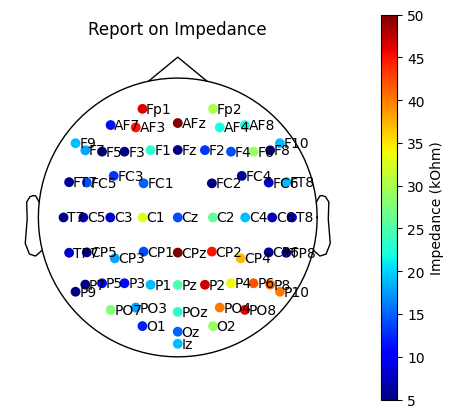

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


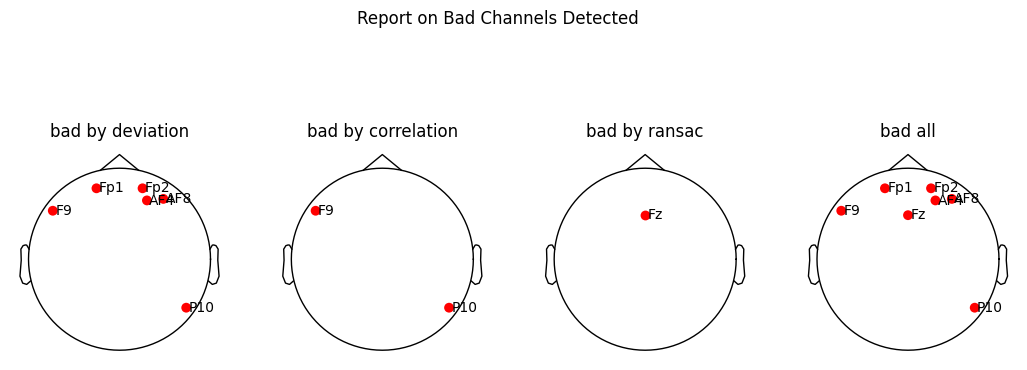

In [4]:
plot_impedance(raw, vmin = 5, vmax = 50)
plot_report_bads(raw,output.noisy_channels_before_interpolation)

# Computing ICA

In [5]:
raw.notch_filter(60)
raw.filter(0.5,None)
ica = mne.preprocessing.ICA(method = 'picard')
ica.fit(raw)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
2024-11-17 21:20:20,346 - numexpr.utils - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-11-17 21:20:20,348 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 64 components
Fitting ICA took 117.4s.


Method,picard
Fit parameters,max_iter=500
Fit,142 iterations on raw data (571085 samples)
ICA components,64
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


# ICA Blinks Removal

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [ 0 31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 425 significant peaks
Number of EOG events detected: 425
Not setting metadata
425 matching events found
No baseline correction applied
Using data from preloaded Raw for 425 events and 251 original time points ...
1 bad epochs dropped
Applying baseline co

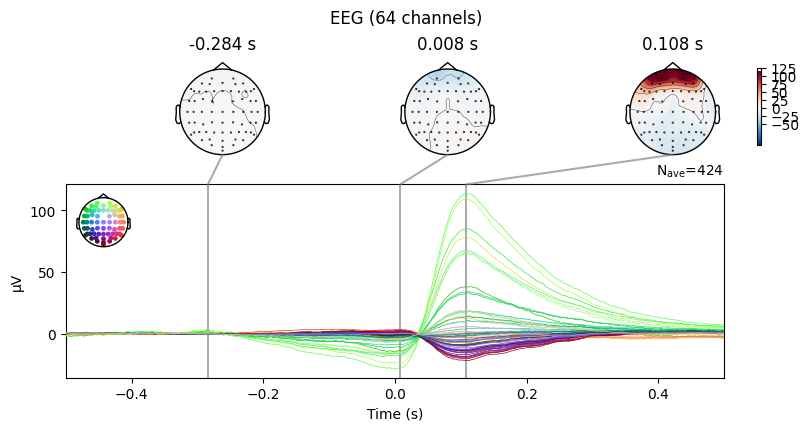

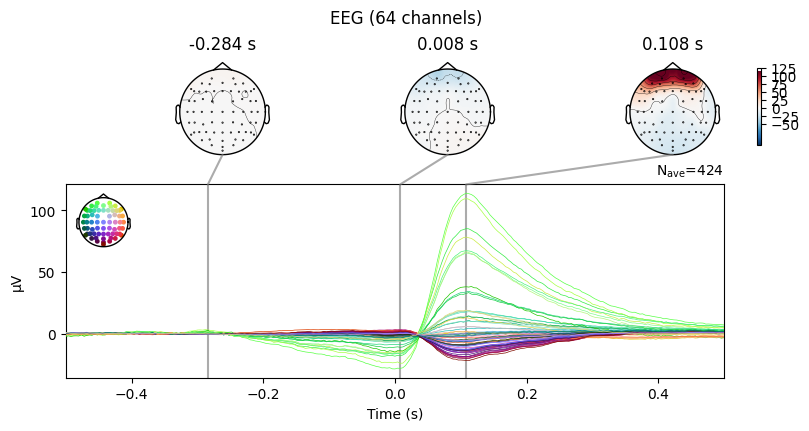

In [6]:
eog_evoked = mne.preprocessing.create_eog_epochs(raw, ch_name = ['Fp1','Fp2']).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 sam

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)



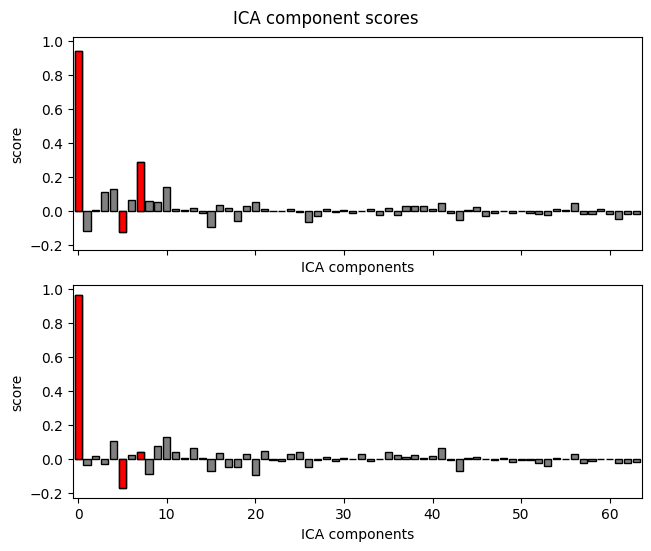

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
1142 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1142 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1142 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1142 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1142 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
1142 matching events found
No baseline correction applied
0 projection items activated


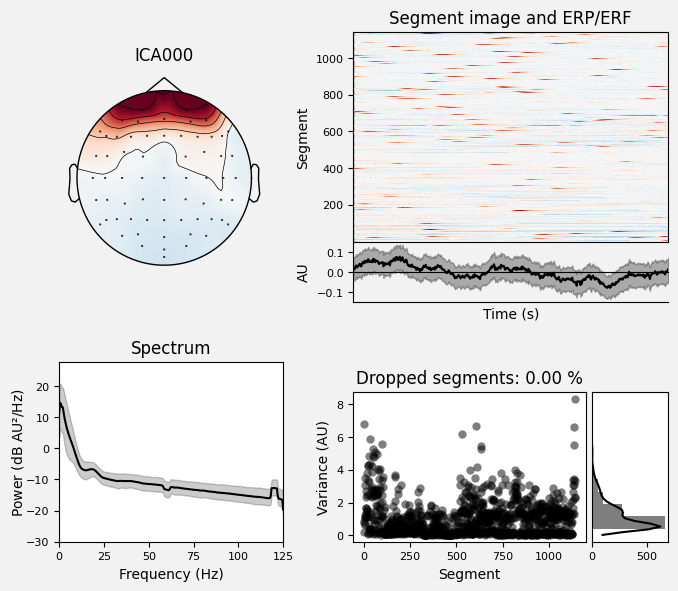

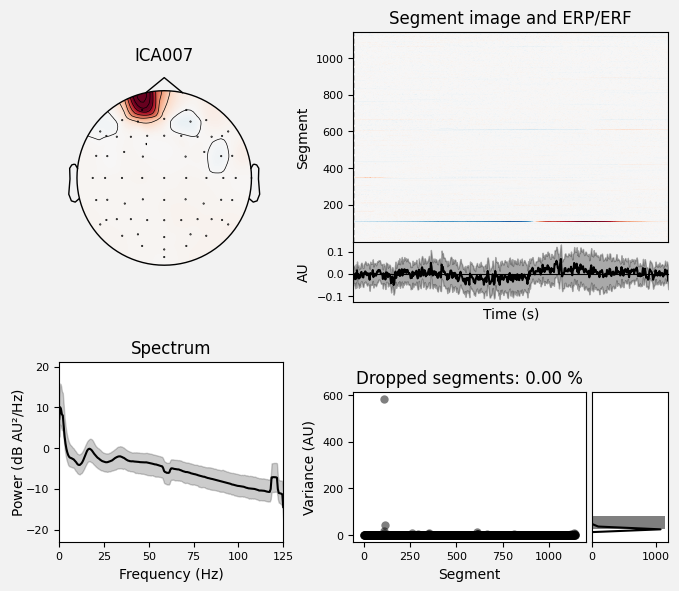

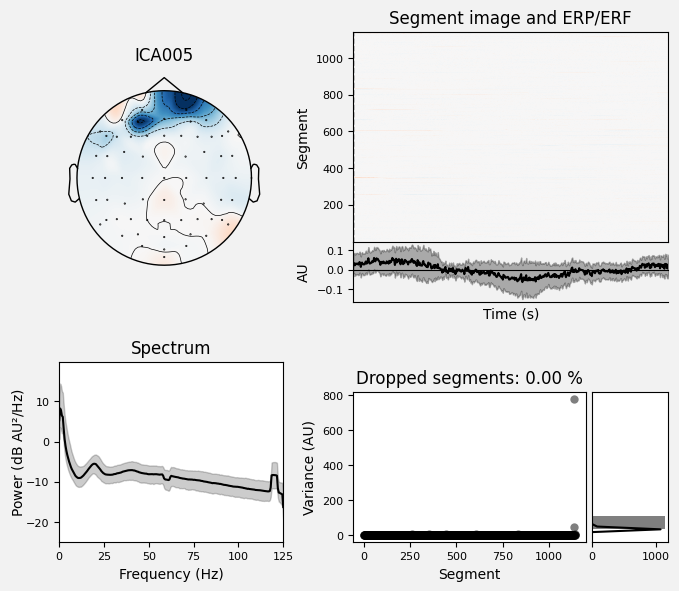

Creating RawArray with float64 data, n_channels=64, n_times=571085
    Range : 0 ... 571084 =      0.000 ...  2284.336 secs
Ready.


2024-11-17 21:22:28,618 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Using qt as 2D backend.


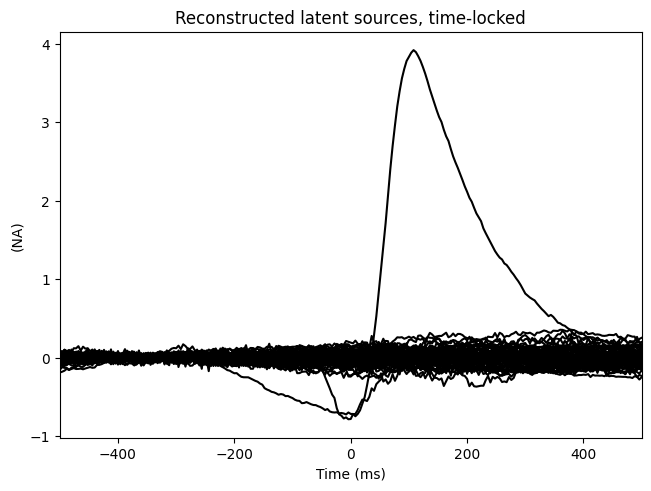

Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 3 ICA components
    Projecting back using 64 PCA components


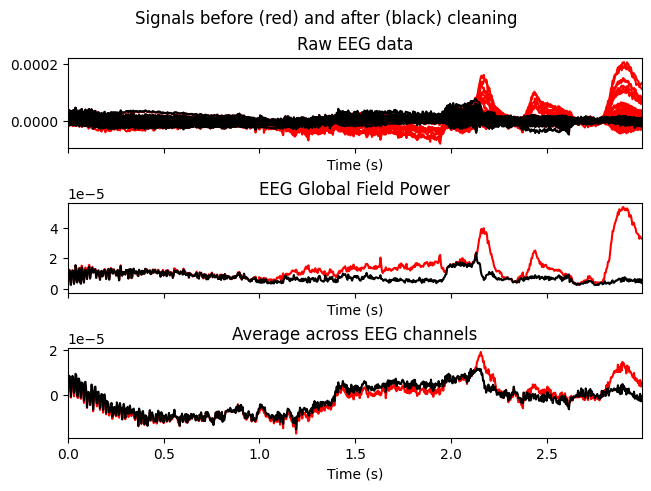

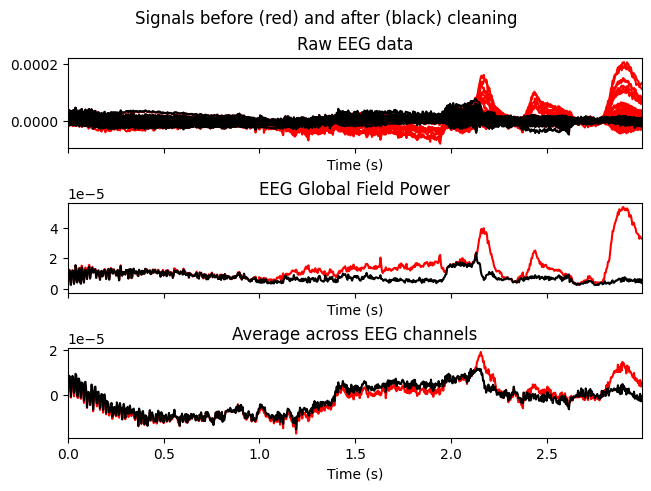

In [7]:
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name = ['Fp1','Fp2'],)
ica.plot_scores(eog_scores, exclude = eog_indices)
ica.plot_properties(raw, picks=eog_indices)
ica.plot_sources(raw, show_scrollbars=False)
ica.plot_sources(eog_evoked)
ica.plot_overlay(raw, exclude=eog_indices, picks="eeg")

# SSP Blinks Removal

Running EOG SSP computation
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [ 0 31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 425 significant peaks
Number of EOG events detected: 425
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pa

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Not setting metadata
425 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 425 events and 101 original time points ...
0 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.200-PCA-01 (exp var=99.4%)
Done.


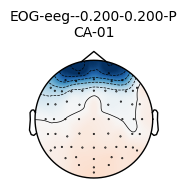

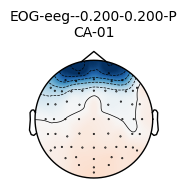

In [8]:
eog_projs, _ = mne.preprocessing.compute_proj_eog(
    raw, n_eeg=1, reject=None, no_proj=True,
    ch_name = ['Fp1','Fp2']
)
mne.viz.plot_projs_topomap(eog_projs, info=raw.info)

1 projection items deactivated


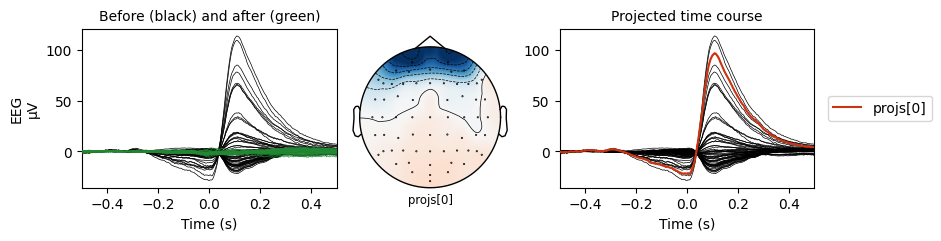

Text(0.5, 0.98, 'EOG projectors')

In [9]:
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked)
fig.suptitle("EOG projectors")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Using matplotlib as 2D backend.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


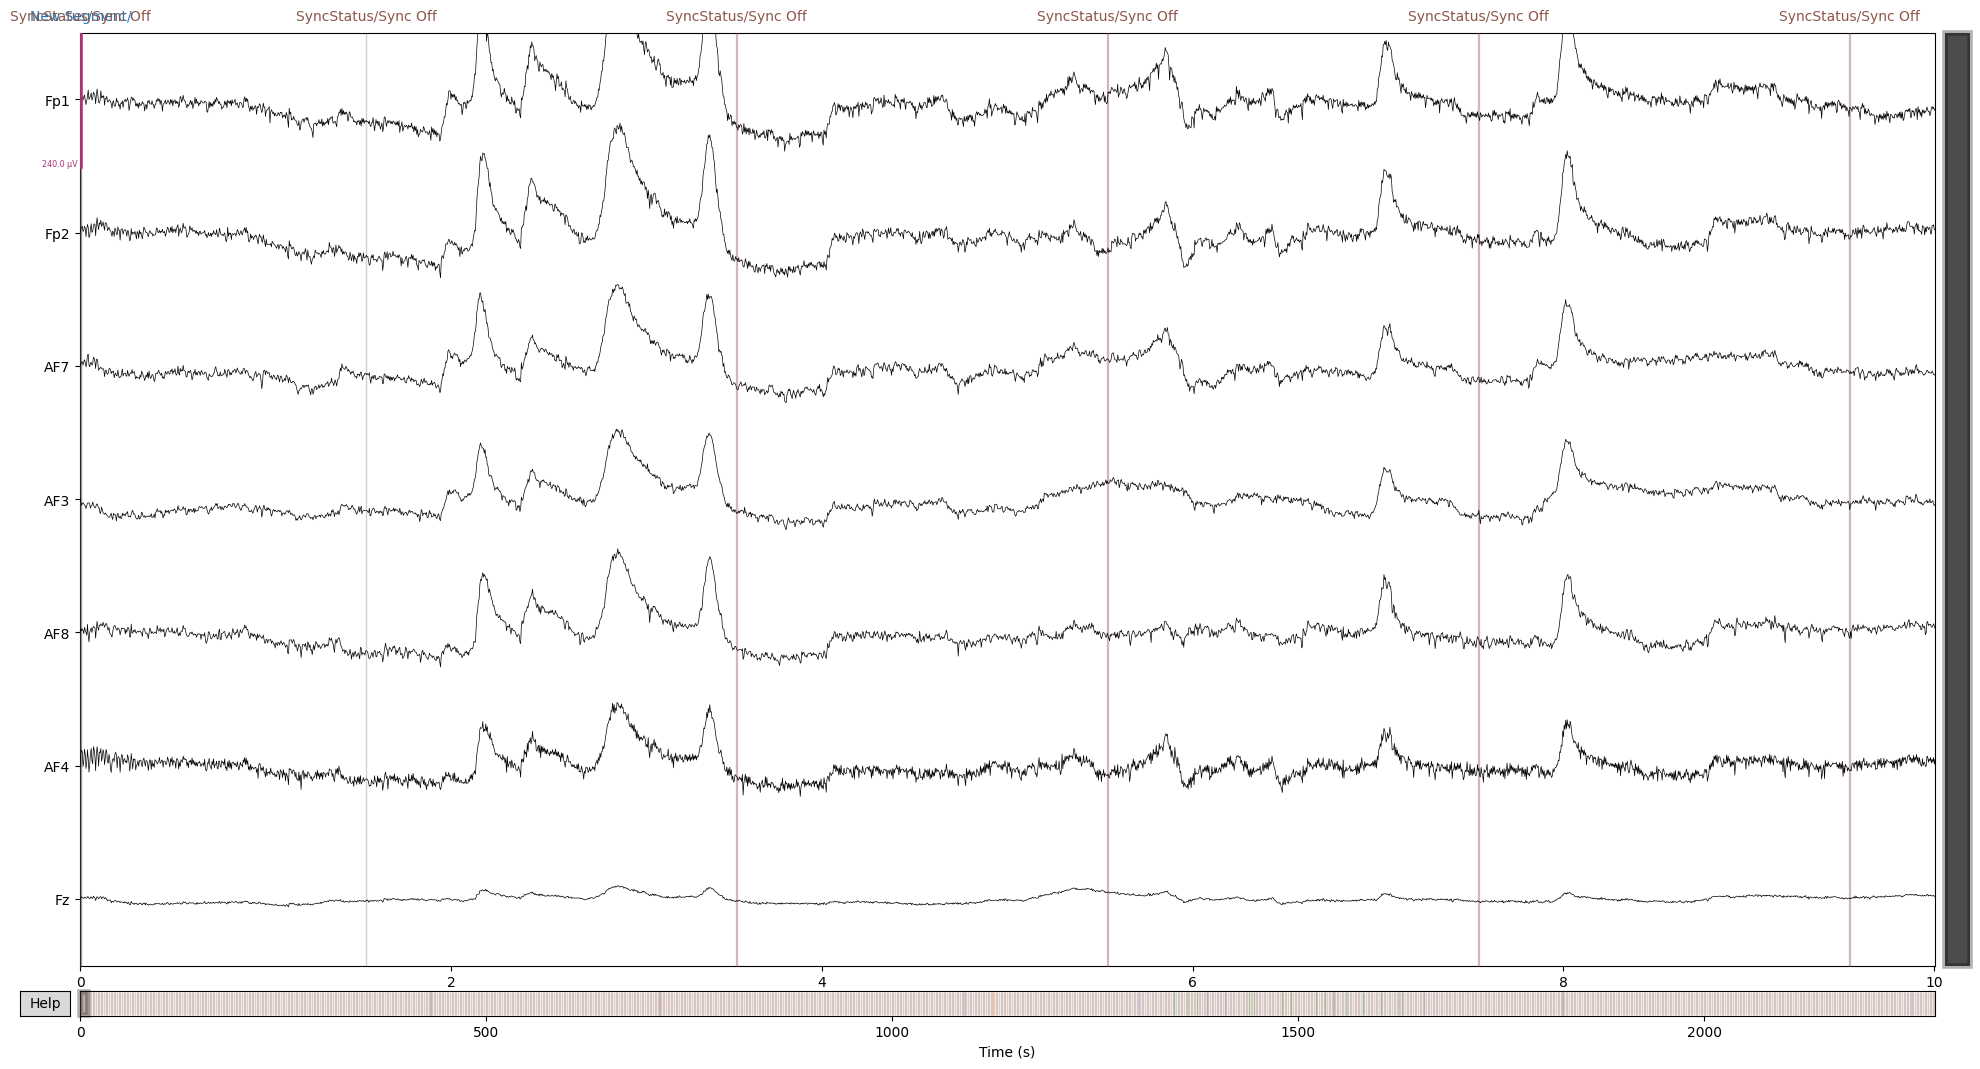

Using qt as 2D backend.
1 projection items deactivated
Using matplotlib as 2D backend.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/home/samuel/anaconda3/envs/mne/lib/python3.12/site-packages/matplotlib_inline/backend_inline.py:27: RuntimeWarning: Projection vector 'EOG-eeg--0.200-0.200-PCA-01' has been reduced to 86.54% of its original magnitude by subselecting 7/64 of the original channels. If the ignored channels were bad during SSP computation, we recommend recomputing proj (via compute_proj_raw or related functions) with the bad channels properly marked, because computing SSP with bad channels present in the data but unmarked is dangerous (it can bias the PCA used by SSP). On the other hand, if you know that all channels were good during SSP computation, you can safely use info.normalize_proj() to suppress this warning during projection.
  return new_figure_manager_given_figure(num, FigureClass(*args, **kwargs))


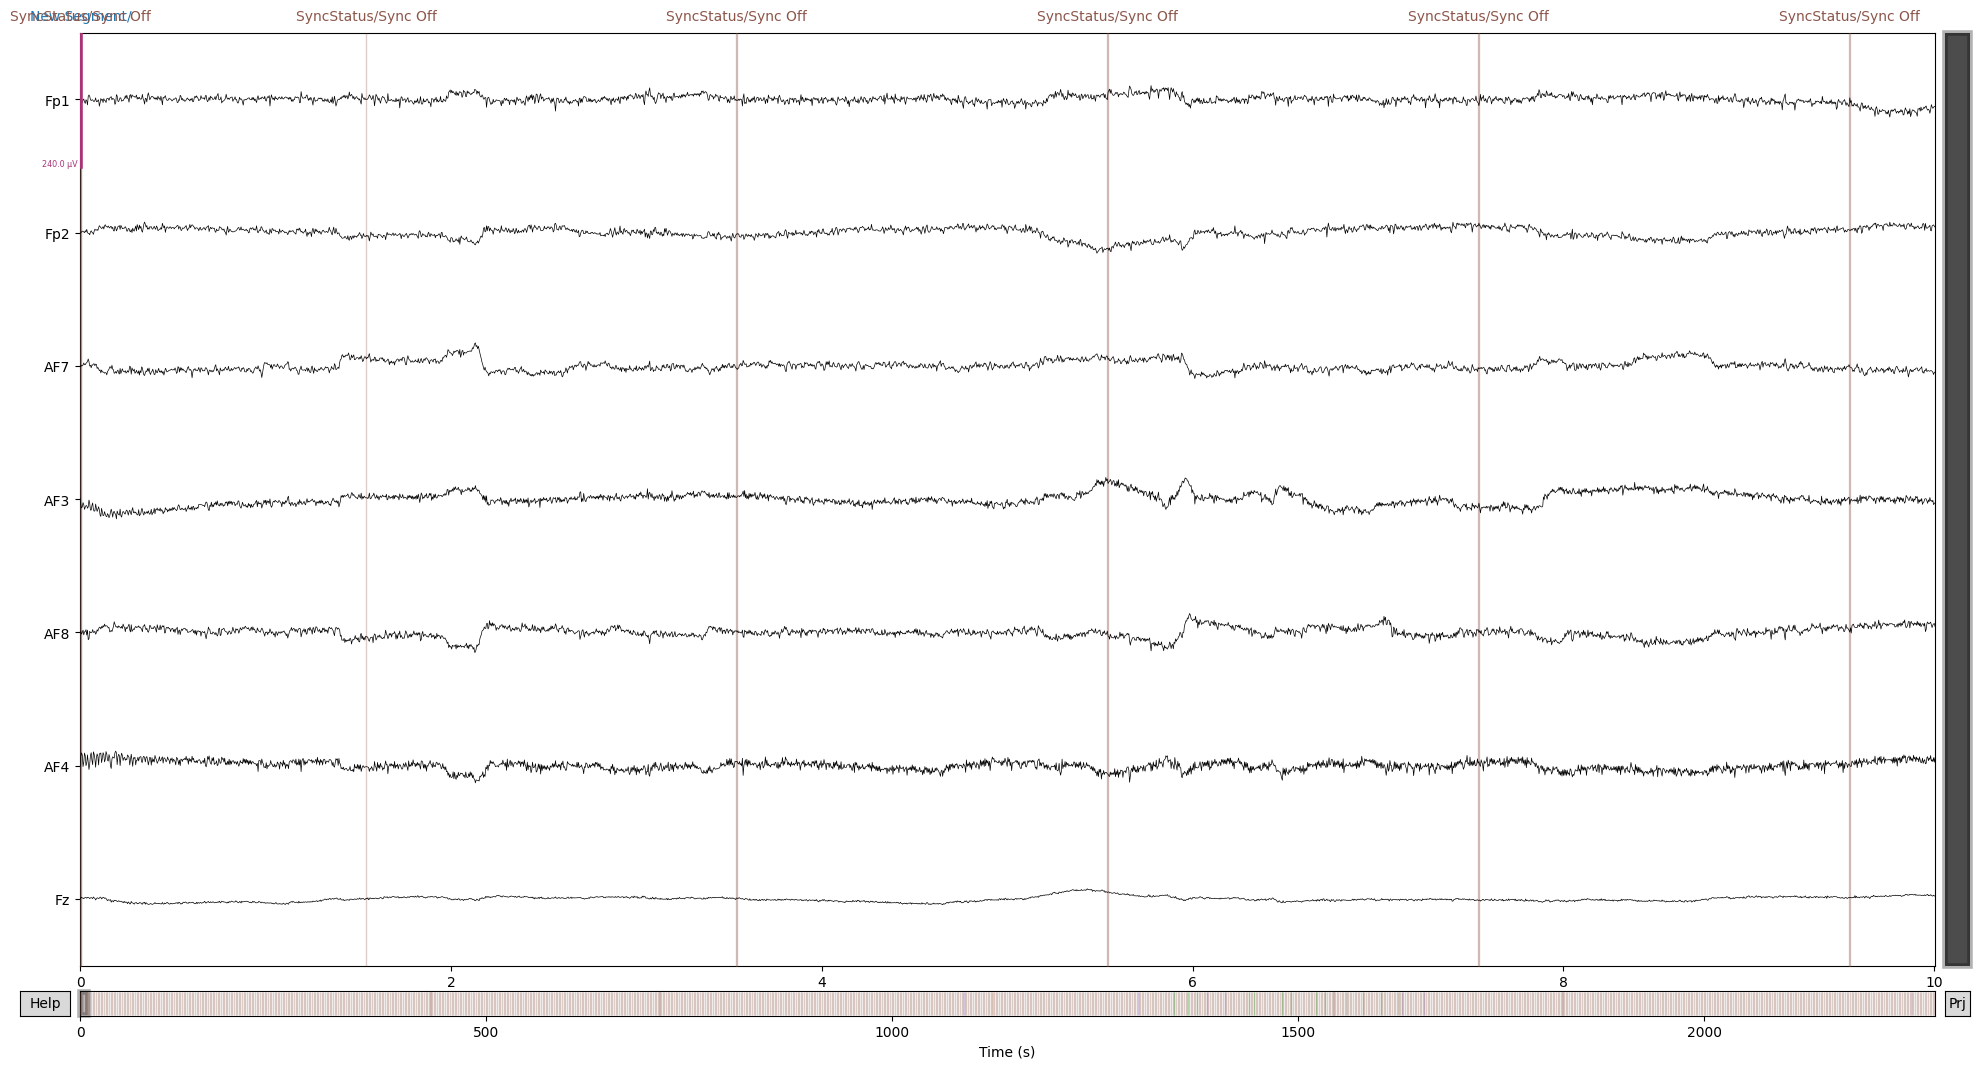

Using qt as 2D backend.


In [11]:
raw.notch_filter(60)
for title in ("Without", "With"):
    if title == "With":
        new_raw = raw.add_proj(eog_projs)
    with mne.viz.use_browser_backend("matplotlib"):
        fig = raw.copy().pick_channels(['Fp1','Fp2','AF7','AF3','AF8','AF4','Fz']).plot(scalings = {'eeg': 120e-6})
    fig.subplots_adjust(top=0.9)  # make room for title
    fig.suptitle(f"{title} EOG projectors", size="xx-large", weight="bold")

# ICA Muscle Artifacts Removal

Effective window size : 8.192 (s)


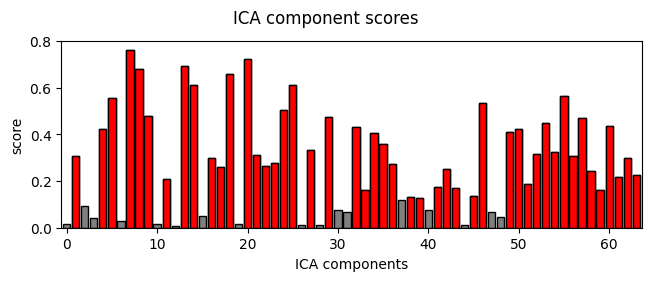

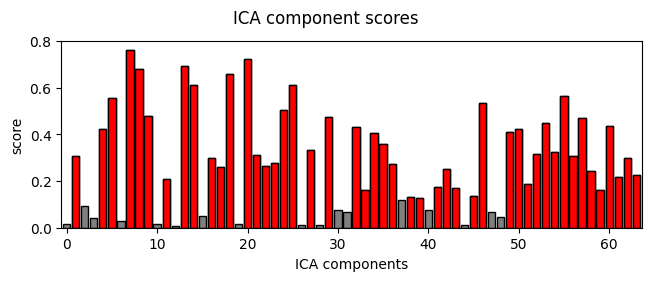

In [12]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_scores(scores, exclude=muscle_idx_auto)

As we can see the majority of components are automatically detected as muscle components.
We can't remove all of them without removing important brain signal also. We need to put maximum number of component we can remove.
This will be a percentage of the total number of components. Of course in the pipeline we will need to flag also that this data as noisy data.
Let's remove the 10% higher muscle components:

In [13]:
percentage = np.ceil(10*len(raw.info['ch_names'])/100)
sorted_scores = set(scores.argsort()[:int(percentage)])
selected = list(sorted_scores.intersection(set(muscle_idx_auto)))
ica.exclude = selected
raw_cleaned = ica.apply(raw)



Applying ICA to Raw instance
    Transforming to ICA space (64 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


In [14]:
raw.plot()

Channels marked as bad:
none


# Z-score Residual Muscle Artifacts Annotation

# Signal metrics

In [4]:
import mne
from eeg_research.analysis.pipelines.signal_metrics import SignalMetrics
raw = mne.io.read_raw_brainvision('/media/samuel/Data/01_projects/proj-rockland_sample_cleaning_data/sub-M10916135_ses-MOBI1A_run-001.vhdr',preload = True)
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage, on_missing='raise')
filtered_raw = raw.copy().filter(0.5,125).resample(250).notch_filter(60)
metrics_raw = SignalMetrics(raw)
metrics_filtered_raw = SignalMetrics(filtered_raw)
metrics_raw.calculate_time_metrics()
metrics_filtered_raw.calculate_time_metrics()

Extracting parameters from /media/samuel/Data/01_projects/proj-rockland_sample_cleaning_data/sub-M10916135_ses-MOBI1A_run-001.vhdr...
Setting channel info structure...
Reading 0 ... 2284339  =      0.000 ...  2284.339 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


In [29]:
from mne.viz.utils import _plot_sensors_2d
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

/tmp/ipykernel_63390/3089373140.py:19: RuntimeWarning: divide by zero encountered in divide
  zscore = np.divide(subtracted,ref_std)
/tmp/ipykernel_63390/3089373140.py:19: RuntimeWarning: invalid value encountered in divide
  zscore = np.divide(subtracted,ref_std)


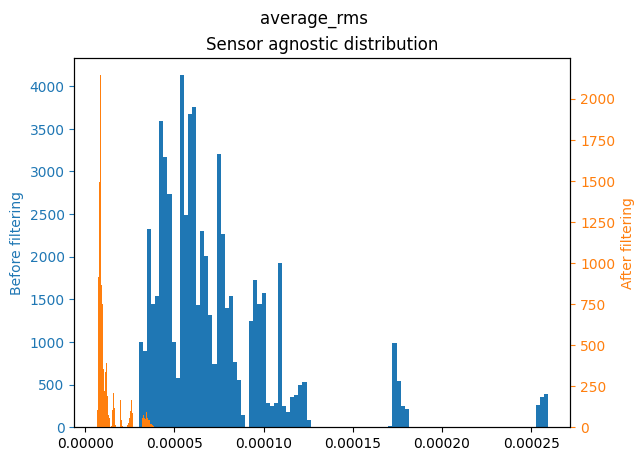

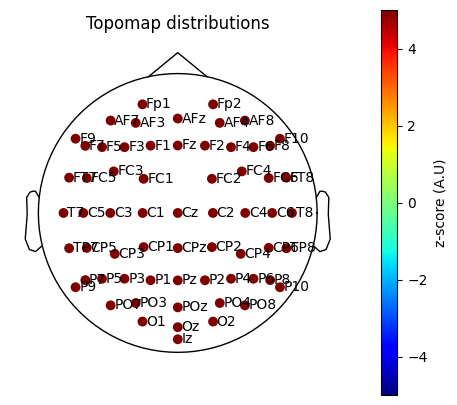

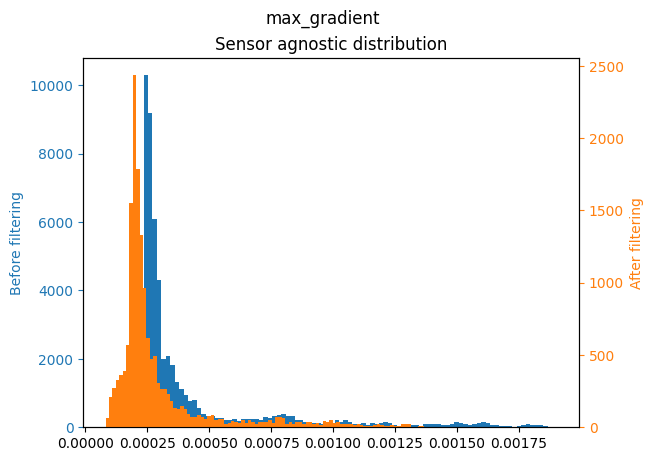

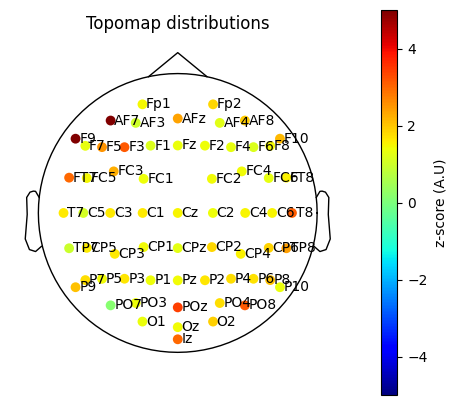

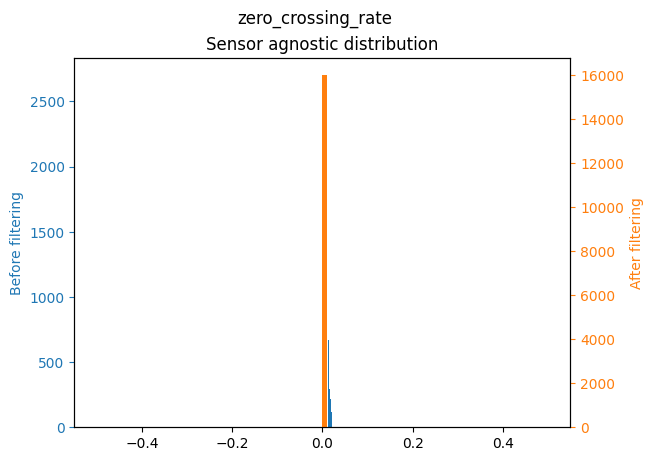

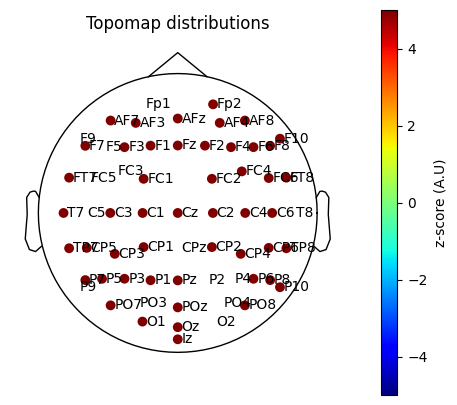

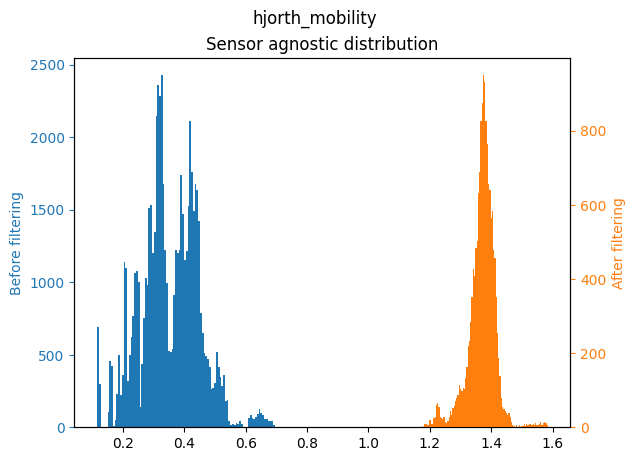

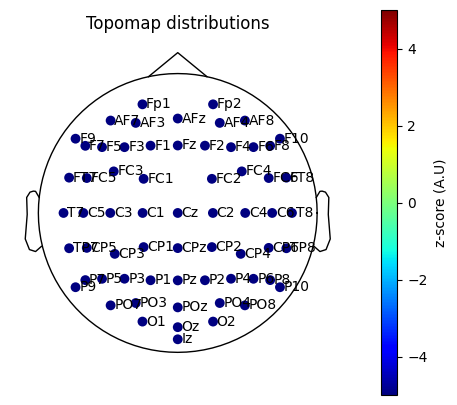

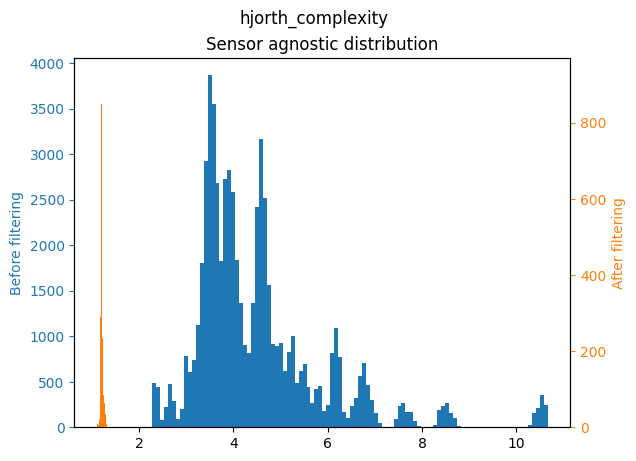

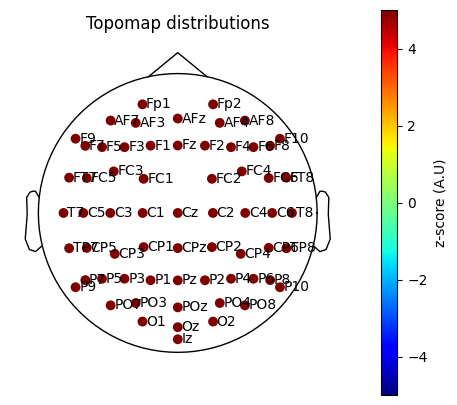

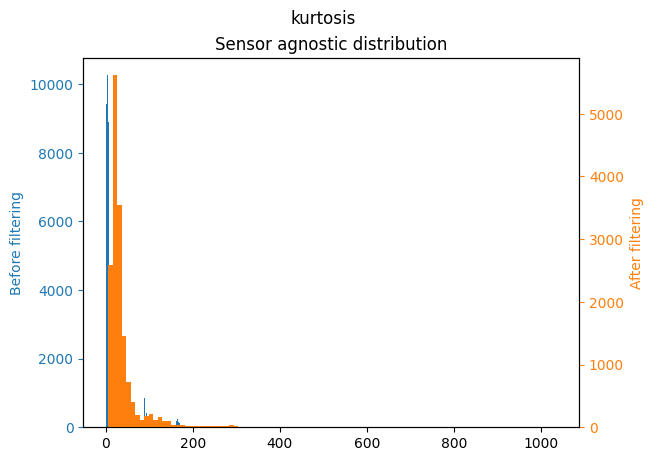

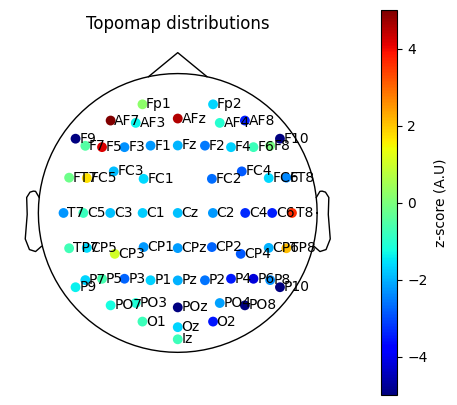

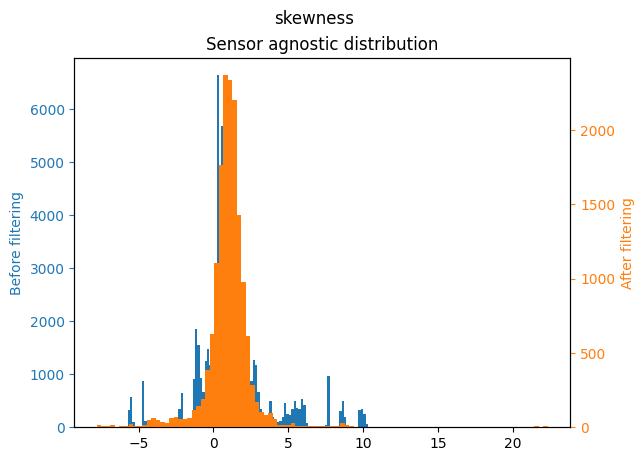

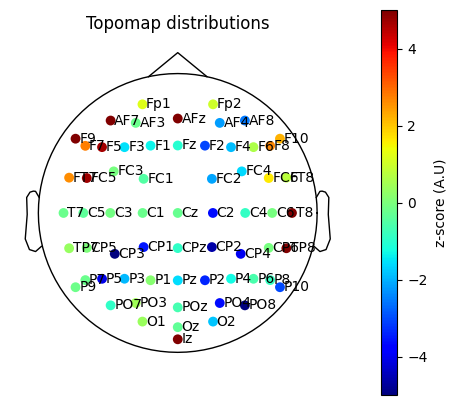

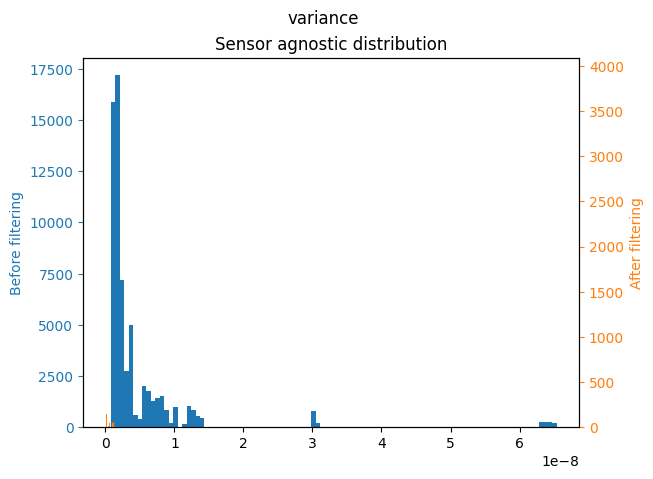

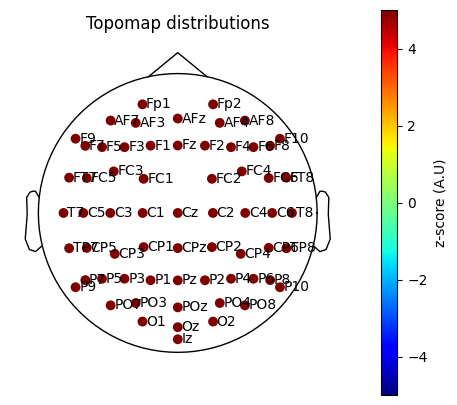

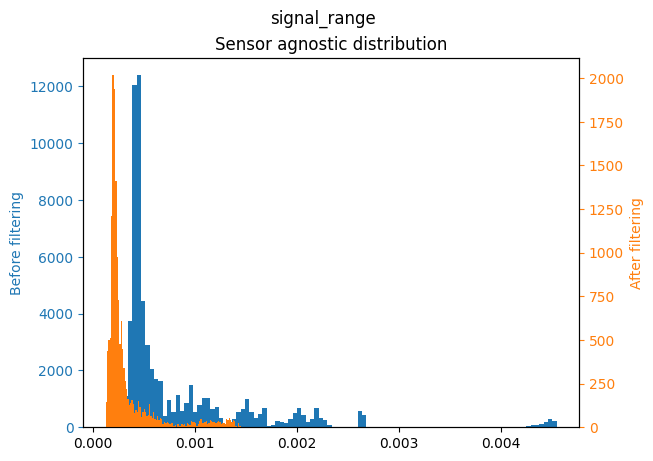

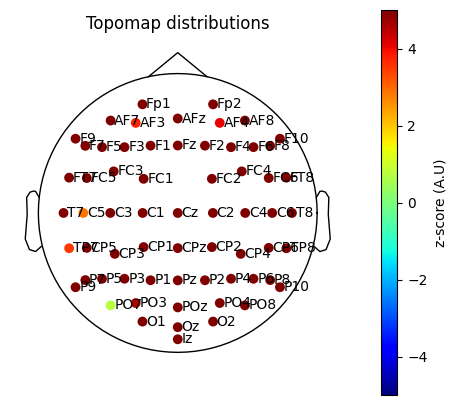

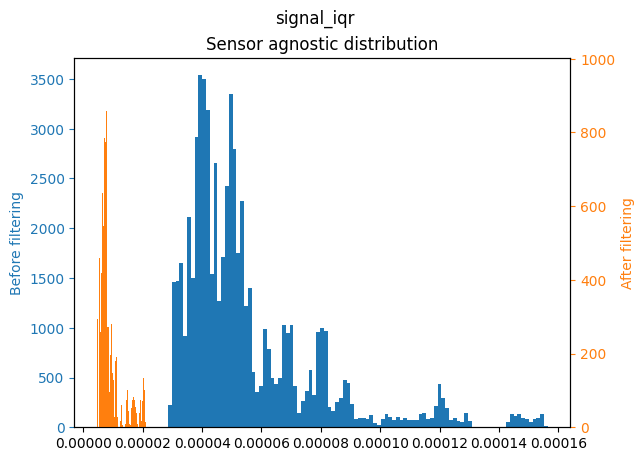

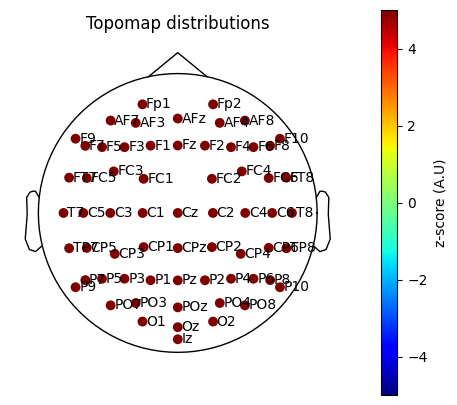

In [75]:
metric_names = [
            "average_rms",
            "max_gradient",
            "zero_crossing_rate",
            "hjorth_mobility",
            "hjorth_complexity",
            "kurtosis",
            "skewness",
            "variance",
            "signal_range",
            "signal_iqr",
        ]
for metric_name in metric_names:
    metric = getattr(metrics_raw, metric_name)
    metric_filt = getattr(metrics_filtered_raw, metric_name)
    ref_std = np.std(metric_filt, axis = 1)
    ref_mean = np.mean(metric_filt, axis = 1)
    subtracted = np.subtract(metric.T,ref_mean)
    zscore = np.divide(subtracted,ref_std)
    mean_zscore = np.mean(zscore, axis = 0) 

    #figure.gca().set_subplotspec(
    #ax = plt.subplot2grid((1,8),(0,6), colspan=2)
    blue = "tab:blue"
    #ax1 = plt.subplot2grid((1,8),(0,0), colspan=5)
    _, ax1 = plt.subplots()
    #ax1 = figure.add_subplot(1,3,1)
    ax1.hist(metric.flatten(), label = "Before filtering", bins = 100)
    ax1.set_ylabel("Before filtering", color = blue)
    ax1.tick_params(axis = 'y', color = blue, labelcolor = blue)
    ax2 = ax1.twinx()
    orange = "tab:orange"
    ax2.hist(metric_filt.flatten(), label = "After filtering", bins = 100,
             color = orange)
    ax2.set_ylabel("After filtering", color = orange)
    ax2.tick_params(axis = 'y', color = orange, labelcolor = orange)
    plt.suptitle(metric_name)
    ax1.set_title("Sensor agnostic distribution")
    #figure.set_size_inches(15,8)

    figure = plot_metrics(metrics_raw.mne_object,
                 z_score = mean_zscore, 
                 title = "Topomap distributions", 
                 show_names = True,
                 vmin = -5,
                 vmax = +5,
                 show = False
                 )
    
